# Name: Margaret Nguyen

## Machine Learning: Principal Component Analysis (PCA) and Ordinary Least Squares (OLS)

In [4]:
# Import packages
import numpy as np # v 1.21.5
import sklearn # v 1.0.2
import pandas as pd # v 1.4.4
import ydata_profiling as pp # v 3.6.6
import statsmodels.api as sm # v 0.13.2

# Regression
from sklearn.linear_model import LinearRegression # v 1.0.2
from sklearn.model_selection import train_test_split # v 1.0.2

# PCA
from sklearn.decomposition import PCA # v 1.0.2
from sklearn.preprocessing import StandardScaler # v 1.0.2

from sklearn.metrics import mean_absolute_error # v 1.0.2
from sklearn.metrics import mean_squared_error # v 1.0.2
from sklearn.metrics import mean_absolute_percentage_error # v 1.0.2

# Ploting libraries 
import matplotlib
#matplotlib.use('Qt5Agg')  # Use an appropriate backend like 'Qt5Agg' for GUI display
import matplotlib.pyplot as plt # v 3.5.2
import seaborn as sns # v 0.11.2
# Display any generated plots or visualizations directly in the notebook interface
%matplotlib inline 

### I. Data Cleaning and Manipulation

In [6]:
# Read the csv file 
df_pa_acs = pd.read_csv('/Users/margaret06/Documents/GitHub/Carlisle_Borough_Transportation_Study/data/2017_TO_2021_MUNI_CRASH_DATA.csv')
df_mass_acs = pd.read_csv('/Users/margaret06/Documents/GitHub/Carlisle_Borough_Transportation_Study/data/df_mass_acs.csv')

/var/folders/vw/dbzntfg96b58pmmcc2cxykdh0000gn/T/ipykernel_5494/2936905132.py:3: DtypeWarning: Columns (35,68) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mass_acs = pd.read_csv('/Users/margaret06/Documents/GitHub/Carlisle_Borough_Transportation_Study/data/df_mass_acs.csv')


**Clean the Pennsylvania crash dataset**

In [7]:
# Clean datasets
df_pa_acs = df_pa_acs.drop(columns = ['Unnamed: 0'])

# Select columns with numeric data types (int or float) using select_dtypes
numeric_columns = df_pa_acs.select_dtypes(include=['number'])

# Create a new DataFrame with only the numeric columns
df_pa_crash = df_pa_acs[numeric_columns.columns]

# Drop unnessary columns
df_pa_crash = df_pa_crash.drop(['PENN_DOT_MUNI_ID', 'state', 'county', 'county_subdivision', 'LAND_AREA.1', 'LAND_AREA', 'PENN_DOT_COUNTY_NUM', 'FEDERAL_EIN_CODE', 'HOME_RULE_YEAR', 'INCORPORATION_YEAR', 'MUNICIPALITY'], axis=1)

# Replace NaN values with 0 in the entire DataFrame
df_pa_crash = df_pa_crash.fillna(0)

# Drop population == 0 (small municipalities)
df_pa_crash = df_pa_crash[df_pa_crash['POPULATION'] != 0]

# Reset index
df_pa_crash.reset_index(inplace = True, drop = True)

**Define the columns for which you want to calculate per capita values**

In [8]:
# Define the columns for which you want to calculate per capita values
columns_to_convert = [
    'BIKE_TO_WORK_EST', 'BIKE_TO_WORK_MARG',
    'WALK_TO_WORK_EST', 'WALK_TO_WORK_MARG', 'DRIVE_SOLO_TO_WORK_EST',
    'DRIVE_SOLO_TO_WORK_MARG', 'CARPOOL_TO_WORK_EST',
    'CARPOOL_TO_WORK_MARG', 'PUBTRANS_TO_WORK_EST',
    'PUBTRANS_TO_WORK_MARG', 'EMPLOYEES_FULL_TIME',
    'EMPLOYEES_PART_TIME', 'AUTOMOBILE_COUNT',
    'BICYCLE_BY_AUTO_COUNT', 'BICYCLE_DEATH_BY_AUTO_COUNT',
    'BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT', 'PED_BY_AUTO_COUNT',
    'PED_DEATH_BY_AUTO_COUNT', 'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT',
    'BICYCLE_SOLO_COUNT', 'BICYCLE_DEATH_SOLO_COUNT',
    'BICYCLE_SUSP_SERIOUS_INJ_SOLO_COUNT', 'PED_SOLO_COUNT',
    'PED_DEATH_SOLO_COUNT', 'PED_SUSP_SERIOUS_INJ_SOLO_COUNT'
]

# Create new columns with "_PER_CAPITA" suffix by dividing each column by 'POPULATION'
for column in columns_to_convert:
    new_column_name = column + '_PER_CAPITA'
    df_pa_crash[new_column_name] = df_pa_crash[column] / df_pa_crash['POPULATION']

**Clean the Massachusett crash dataset**

In [9]:
# Clean datasets
df_mass_acs = df_mass_acs.drop(columns = ['Unnamed: 0'])

# Exclude the NaN from 'VEHC_CONFIG_CL'
df_mass_crash = df_mass_acs[df_mass_acs['VEHC_CONFIG_CL'].notna()]

# Drop population == 0 (small municipalities)
df_mass_crash = df_mass_crash[df_mass_crash['POPULATION'] != 0]

# List of NOT automobiles: Snowmobile, Moped, Motorcycle, Other Light Trucks (10,000 lbs., or Less), Other e.g. Farm Equipment, Unknown.
# Exclude the non-automobiles from 'VEHC_CONFIG_CL' columns
list_non_automobiles = ['V1:(Unknown vehicle configuration)', 'V1:(Other e.g. farm equipment)', 'V1:(Unknown vehicle configuration) / V2:(Unknown vehicle configuration)']
df_mass_crash= df_mass_crash[~df_mass_crash['VEHC_CONFIG_CL'].isin(list_non_automobiles)]

In [10]:
# Fatal - injuries that resulted in death 
# Incapacitating - serious injuries require immediate medical attention

## BICYCLE_DEATH_BY_AUTO_COUNT
# Filter the DataFrame for cyclist fatalities
cyclist_fatalities = df_mass_crash[(df_mass_crash['INJY_STAT_DESCR'] == 'Fatal injury (K)') & (df_mass_crash['NON_MTRST_TYPE_CL'] == 'Cyclist')]

# Group the filtered DataFrame by 'CITY_TOWN_NAME' and calculate the count for each city
bicycle_death_counts = cyclist_fatalities.groupby('CITY_TOWN_NAME').size().reset_index(name='BICYCLE_DEATH_BY_AUTO_COUNT')

# Merge the bicycle_death_counts DataFrame into df_mass_crash on 'CITY_TOWN_NAME'
df_mass_crash = df_mass_crash.merge(bicycle_death_counts, on='CITY_TOWN_NAME', how='left')

## BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT
cyclist_incapacitating = df_mass_crash[(df_mass_crash['INJY_STAT_DESCR'] == 'Non-fatal injury - Incapacitating') & (df_mass_crash['NON_MTRST_TYPE_CL'] == 'Cyclist')]
bicycle_sus_serious_inj_counts = cyclist_incapacitating.groupby('CITY_TOWN_NAME').size().reset_index(name='BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT')

# Merge the bicycle_sus_serious_inj_counts DataFrame into df_mass_crash on 'CITY_TOWN_NAME'
df_mass_crash = df_mass_crash.merge(bicycle_sus_serious_inj_counts, on='CITY_TOWN_NAME', how='left')

# Replace NaN values with 0 in the specified columns
df_mass_crash['BICYCLE_DEATH_BY_AUTO_COUNT'].fillna(0, inplace=True)
df_mass_crash['BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT'].fillna(0, inplace=True)

## BICYCLE_BY_AUTO_COUNT
df_mass_crash['BICYCLE_BY_AUTO_COUNT'] = df_mass_crash['BICYCLE_DEATH_BY_AUTO_COUNT'] + df_mass_crash['BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT']

## AUTOMOBILE_COUNT
auto_count = df_mass_crash.groupby('CITY_TOWN_NAME')['NUMB_VEHC'].sum().reset_index()
auto_count.rename(columns={'NUMB_VEHC': 'AUTOMOBILE_COUNT'}, inplace=True)
# Merge the auto_count into df_mass_crash on 'CITY_TOWN_NAME'
df_mass_crash = df_mass_crash.merge(auto_count, on='CITY_TOWN_NAME', how='left')

## PED_DEATH_BY_AUTO_COUNT
# Filter the DataFrame for pedestrian fatalities
ped_fatalities = df_mass_crash[(df_mass_crash['INJY_STAT_DESCR'] == 'Fatal injury (K)') & (df_mass_crash['NON_MTRST_TYPE_CL'] == 'Pedestrian')]

# Group the filtered DataFrame by 'CITY_TOWN_NAME' and calculate the count for each city
ped_death_counts = cyclist_fatalities.groupby('CITY_TOWN_NAME').size().reset_index(name='PED_DEATH_BY_AUTO_COUNT')

# Merge the ped_death_counts DataFrame into df_mass_crash on 'CITY_TOWN_NAME'
df_mass_crash = df_mass_crash.merge(ped_death_counts, on='CITY_TOWN_NAME', how='left')

## PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT
ped_incapacitating = df_mass_crash[(df_mass_crash['INJY_STAT_DESCR'] == 'Non-fatal injury - Incapacitating') & (df_mass_crash['NON_MTRST_TYPE_CL'] == 'Pedestrian')]
ped_sus_serious_inj_counts = ped_incapacitating.groupby('CITY_TOWN_NAME').size().reset_index(name='PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT')

# Merge the ped_sus_serious_inj_counts DataFrame into df_mass_crash on 'CITY_TOWN_NAME'
df_mass_crash = df_mass_crash.merge(ped_sus_serious_inj_counts, on='CITY_TOWN_NAME', how='left')

# Replace NaN values with 0 in the specified columns
df_mass_crash['PED_DEATH_BY_AUTO_COUNT'].fillna(0, inplace=True)
df_mass_crash['PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT'].fillna(0, inplace=True)

##PED_BY_AUTO_COUNT
df_mass_crash['PED_BY_AUTO_COUNT'] = df_mass_crash['PED_DEATH_BY_AUTO_COUNT'] + df_mass_crash['PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT']

# Drop the duplicated rows
df_mass_crash = df_mass_crash.drop_duplicates(subset=['CITY_TOWN_NAME', 'POPULATION', 
                                                      'BIKE_TO_WORK_EST', 'BICYCLE_BY_AUTO_COUNT', 
                                                      'BICYCLE_DEATH_BY_AUTO_COUNT', 
                                                      'BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT', 
                                                      'AUTOMOBILE_COUNT', 'PED_BY_AUTO_COUNT', 
                                                      'PED_DEATH_BY_AUTO_COUNT', 'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT'])

In [11]:
# Select columns with numeric data types (int or float) using select_dtypes
numeric_columns = df_mass_crash.select_dtypes(include=['number'])

# Create a new DataFrame with only the numeric columns
df_mass_crash = df_mass_crash[numeric_columns.columns]

# Reset index
df_mass_crash.reset_index(drop = True, inplace = True)

**Define the columns for which you want to calculate per capita values**

In [12]:
# Define the columns for which you want to calculate per capita values
columns_to_convert = [
    'BIKE_TO_WORK_EST', 'BIKE_TO_WORK_MARG',
    'WALK_TO_WORK_EST', 'WALK_TO_WORK_MARG', 'DRIVE_SOLO_TO_WORK_EST',
    'DRIVE_SOLO_TO_WORK_MARG', 'CARPOOL_TO_WORK_EST',
    'CARPOOL_TO_WORK_MARG', 'PUBTRANS_TO_WORK_EST',
    'PUBTRANS_TO_WORK_MARG', 'AUTOMOBILE_COUNT',
    'BICYCLE_BY_AUTO_COUNT', 'BICYCLE_DEATH_BY_AUTO_COUNT',
    'BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT', 'PED_BY_AUTO_COUNT',
    'PED_DEATH_BY_AUTO_COUNT', 'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT']

# Create new columns with "_PER_CAPITA" suffix by dividing each column by 'POPULATION'
for column in columns_to_convert:
    new_column_name = column + '_PER_CAPITA'
    df_mass_crash[new_column_name] = df_mass_crash[column] / df_mass_crash['POPULATION']

**Create dummy variable for each dataframe**

In [13]:
df_pa_crash['penn'] = 1
df_mass_crash['penn'] = 0

**Make df_mass_crash have the same columns as df_pa_crash**

In [14]:
# Drop columns that df_mass_crash does not have
drop_columns = ['EMPLOYEES_FULL_TIME', 'EMPLOYEES_PART_TIME', 'BICYCLE_SOLO_COUNT', 'BICYCLE_DEATH_SOLO_COUNT', 'BICYCLE_SUSP_SERIOUS_INJ_SOLO_COUNT', 'PED_SOLO_COUNT', 'PED_DEATH_SOLO_COUNT', 'PED_SUSP_SERIOUS_INJ_SOLO_COUNT', 'EMPLOYEES_FULL_TIME_PER_CAPITA', 'EMPLOYEES_PART_TIME_PER_CAPITA', 'BICYCLE_SOLO_COUNT_PER_CAPITA', 'BICYCLE_DEATH_SOLO_COUNT_PER_CAPITA', 'BICYCLE_SUSP_SERIOUS_INJ_SOLO_COUNT_PER_CAPITA', 'PED_SOLO_COUNT_PER_CAPITA', 'PED_DEATH_SOLO_COUNT_PER_CAPITA', 'PED_SUSP_SERIOUS_INJ_SOLO_COUNT_PER_CAPITA']
df_pa_crash = df_pa_crash.drop(columns=drop_columns)

# Reorder the columns of the df_mass_crash to match df_pa_crash
df_mass_crash = df_mass_crash[df_pa_crash.columns]

In [15]:
# Print the shape of each datadrame
df_mass_crash.shape, df_pa_crash.shape

((293, 36), (2565, 36))

**Concatenate two dataframes**

In [16]:
df_crash = pd.concat([df_pa_crash, df_mass_crash], axis=0)
# Reset index
df_crash.reset_index(drop = True, inplace = True)

# Show merge dataframe
df_crash.head()

,POPULATION,BIKE_TO_WORK_EST,BIKE_TO_WORK_MARG,WALK_TO_WORK_EST,WALK_TO_WORK_MARG,DRIVE_SOLO_TO_WORK_EST,DRIVE_SOLO_TO_WORK_MARG,CARPOOL_TO_WORK_EST,CARPOOL_TO_WORK_MARG,PUBTRANS_TO_WORK_EST,...,PUBTRANS_TO_WORK_EST_PER_CAPITA,PUBTRANS_TO_WORK_MARG_PER_CAPITA,AUTOMOBILE_COUNT_PER_CAPITA,BICYCLE_BY_AUTO_COUNT_PER_CAPITA,BICYCLE_DEATH_BY_AUTO_COUNT_PER_CAPITA,BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT_PER_CAPITA,PED_BY_AUTO_COUNT_PER_CAPITA,PED_DEATH_BY_AUTO_COUNT_PER_CAPITA,PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT_PER_CAPITA,penn
0,1596865,14172,940,54269,2031,343702,5207,55482,3121,152058,...,0.095223,0.002617,0.002005,0.000364,0.000005,0.000019,0.001633,0.000051,0.000134,1
1,303207,1920,290,15005,1033,80593,2054,10191,814,23357,...,0.077033,0.004129,0.002032,0.000274,0.000003,0.000013,0.001778,0.000020,0.000247,1
2,40352,729,297,3963,402,6711,800,484,166,1813,...,0.044930,0.009715,0.001512,0.000347,0.000000,0.000050,0.001165,0.000000,0.000074,1
3,95536,329,191,2003,392,28933,1152,5476,668,1482,...,0.015512,0.003266,0.001528,0.000481,0.000010,0.000052,0.001047,0.000031,0.000105,1
4,19236,259,116,335,142,6363,680,1169,336,591,...,0.030724,0.010969,0.000572,0.000260,0.000000,0.000104,0.000208,0.000000,0.000000,1


**Perform Exploratory Data Analysis (EDA) to check for multicollinearity among the independent variables in the dataset**

In [17]:
df_crash.shape, df_crash.dtypes

((2858, 36),
 POPULATION                                             int64
 BIKE_TO_WORK_EST                                       int64
 BIKE_TO_WORK_MARG                                      int64
 WALK_TO_WORK_EST                                       int64
 WALK_TO_WORK_MARG                                      int64
 DRIVE_SOLO_TO_WORK_EST                                 int64
 DRIVE_SOLO_TO_WORK_MARG                                int64
 CARPOOL_TO_WORK_EST                                    int64
 CARPOOL_TO_WORK_MARG                                   int64
 PUBTRANS_TO_WORK_EST                                   int64
 PUBTRANS_TO_WORK_MARG                                  int64
 AUTOMOBILE_COUNT                                     float64
 BICYCLE_BY_AUTO_COUNT                                float64
 BICYCLE_DEATH_BY_AUTO_COUNT                          float64
 BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT               float64
 PED_BY_AUTO_COUNT                                    flo

In [18]:
# Check for NaN missing values
df_crash.isna().sum()

POPULATION                                           0
BIKE_TO_WORK_EST                                     0
BIKE_TO_WORK_MARG                                    0
WALK_TO_WORK_EST                                     0
WALK_TO_WORK_MARG                                    0
DRIVE_SOLO_TO_WORK_EST                               0
DRIVE_SOLO_TO_WORK_MARG                              0
CARPOOL_TO_WORK_EST                                  0
CARPOOL_TO_WORK_MARG                                 0
PUBTRANS_TO_WORK_EST                                 0
PUBTRANS_TO_WORK_MARG                                0
AUTOMOBILE_COUNT                                     0
BICYCLE_BY_AUTO_COUNT                                0
BICYCLE_DEATH_BY_AUTO_COUNT                          0
BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT               0
PED_BY_AUTO_COUNT                                    0
PED_DEATH_BY_AUTO_COUNT                              0
PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT                   0
BIKE_TO_WO

**Use Pandas Profiling**

In [19]:
#pp.ProfileReport(df_crash)

### II. Principal Component Analysis (PCA)

In [20]:
df_crash_filtered = df_crash.copy()

# Drop the binary column while running the PCA
df_crash_filtered.drop(columns=['penn', 'BICYCLE_BY_AUTO_COUNT_PER_CAPITA', 'PED_BY_AUTO_COUNT_PER_CAPITA'], inplace=True)

### Credit:

The following code is based on the work of my supervisor, Mitch Shiles. The original code can be found at this link: [Mitch Shiles' GitHub](https://github.com/rmshiles/Textiles-Spectroscopy-and-Supervised-Learning/blob/master/spectral%20analysis%20Final%20version.ipynb).

In [21]:
# Normalize the features
crash_scaler = StandardScaler()
crash_std = crash_scaler.fit_transform(df_crash_filtered)

In [22]:
#create a function to display the explained Variance related to principle components
def Number_of_Principle_Components(X_standardized,n_components):
    #Dimensionality reduction 
    # conduct principle compenent analysis on the data and examine the explained variance of the components
    from sklearn.decomposition import PCA
    sklearn_pca = PCA(n_components=n_components)
    Y_sklearn = sklearn_pca.fit_transform(X_standardized)
    pca = sklearn_pca.fit_transform(crash_std)
    plt.plot(sklearn_pca.explained_variance_ratio_)
    plt.show()
    print(
        'The percentage of total variance in the dataset explained by each',
        'component from Sklearn PCA.\n',
        sklearn_pca.explained_variance_ratio_
    )

    explained_variance = []
    explained_variance = sklearn_pca.explained_variance_ratio_

    total_variace = 0
    total_variace = 0
    components = 0
    num_prints = 0
    print('\n')
    for v in explained_variance:
        total_variace+=v
        components +=1

        if total_variace>=0.5 and total_variace<0.7 and num_prints < 1 :
            print(" to retain {}% of total variance  {} components are required".format(round(100*total_variace,2),components))
            num_prints+=1

        if total_variace>=0.7 and total_variace<0.8 and num_prints < 2 :
            print(" to retain {}% of total variance {} components required".format(round(100*total_variace,2),components))
            num_prints+=1

        elif total_variace>=0.8 and total_variace<0.9 and num_prints < 3 :
            print(" to retain {}% of total variance {} components required".format(round(100*total_variace,2),components))
            num_prints+=1

        elif total_variace>=0.9 and num_prints < 4  :
            print(" to retain {}% of total variance {} components required".format(round(100*total_variace,2),components))
            num_prints+=1

        else:
            None

    print(sum(explained_variance))

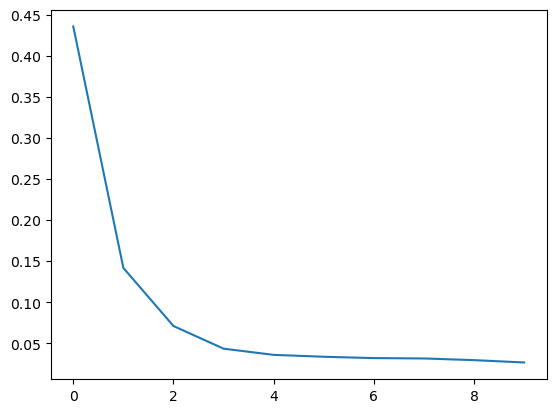

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.43546111 0.14156504 0.07085162 0.04328917 0.03575381 0.03343929
 0.0318242  0.03136395 0.02932971 0.02648559]


 to retain 57.7% of total variance  2 components are required
 to retain 72.69% of total variance 5 components required
 to retain 82.35% of total variance 8 components required
0.8793634907407653


In [23]:
Number_of_Principle_Components(crash_std,10)

In [24]:
n_components=8
pca = PCA(n_components)
crash_pca_components = pca.fit_transform(crash_std)
print(crash_pca_components)

[[ 1.61280938e+02  9.66351850e+00  3.74174974e+01 ...  2.33310925e-01
   6.57378561e+00  7.95904428e-01]
 [ 3.45242693e+01  6.91444269e-01 -8.32243360e-01 ...  1.50413766e-01
   2.27606910e-01 -2.40121229e+00]
 [ 7.97921982e+00 -2.94505691e-01 -6.50565130e+00 ... -3.33913295e+00
  -3.12160934e-01 -5.01036295e-01]
 ...
 [-5.53438882e-01 -7.35966489e-02 -2.69563805e-01 ... -1.03688074e+00
   2.33970985e-01 -2.33382828e-01]
 [-5.07157496e-01 -2.14537083e-01  3.73798693e-01 ...  1.08216863e-01
  -2.50865005e-01  1.49672695e-01]
 [-7.33866914e-01 -1.57466361e-01  7.77112377e-01 ... -1.64534976e+00
  -4.21674909e-01 -3.61329091e-01]]


In [25]:
df_crash_filtered[["PCA1", "PCA2", "PCA3", "PCA4", "PCA5", "PCA6", "PCA7", "PCA8"]] = crash_pca_components[:]
df_crash_filtered[["PCA1","PCA2","PCA3","PCA4","PCA5","PCA6","PCA7","PCA8"]].head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8
0,161.280938,9.663519,37.417497,4.230085,-2.388878,0.233311,6.573786,0.795904
1,34.524269,0.691444,-0.832243,0.444581,-2.346185,0.150414,0.227607,-2.401212
2,7.979220,-0.294506,-6.505651,6.090161,-0.133281,-3.339133,-0.312161,-0.501036
3,12.541762,-0.424664,-1.818447,-0.834159,0.452471,1.738538,-0.262577,1.195549
4,3.684346,-0.569089,-3.355289,1.077887,-0.420376,-0.233662,-0.901839,1.719494


In [26]:
df_crash_filtered.columns

Index(['POPULATION', 'BIKE_TO_WORK_EST', 'BIKE_TO_WORK_MARG',
       'WALK_TO_WORK_EST', 'WALK_TO_WORK_MARG', 'DRIVE_SOLO_TO_WORK_EST',
       'DRIVE_SOLO_TO_WORK_MARG', 'CARPOOL_TO_WORK_EST',
       'CARPOOL_TO_WORK_MARG', 'PUBTRANS_TO_WORK_EST', 'PUBTRANS_TO_WORK_MARG',
       'AUTOMOBILE_COUNT', 'BICYCLE_BY_AUTO_COUNT',
       'BICYCLE_DEATH_BY_AUTO_COUNT', 'BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT',
       'PED_BY_AUTO_COUNT', 'PED_DEATH_BY_AUTO_COUNT',
       'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT', 'BIKE_TO_WORK_EST_PER_CAPITA',
       'BIKE_TO_WORK_MARG_PER_CAPITA', 'WALK_TO_WORK_EST_PER_CAPITA',
       'WALK_TO_WORK_MARG_PER_CAPITA', 'DRIVE_SOLO_TO_WORK_EST_PER_CAPITA',
       'DRIVE_SOLO_TO_WORK_MARG_PER_CAPITA', 'CARPOOL_TO_WORK_EST_PER_CAPITA',
       'CARPOOL_TO_WORK_MARG_PER_CAPITA', 'PUBTRANS_TO_WORK_EST_PER_CAPITA',
       'PUBTRANS_TO_WORK_MARG_PER_CAPITA', 'AUTOMOBILE_COUNT_PER_CAPITA',
       'BICYCLE_DEATH_BY_AUTO_COUNT_PER_CAPITA',
       'BICYCLE_SUSP_SERIOUS_INJ_BY_AUT

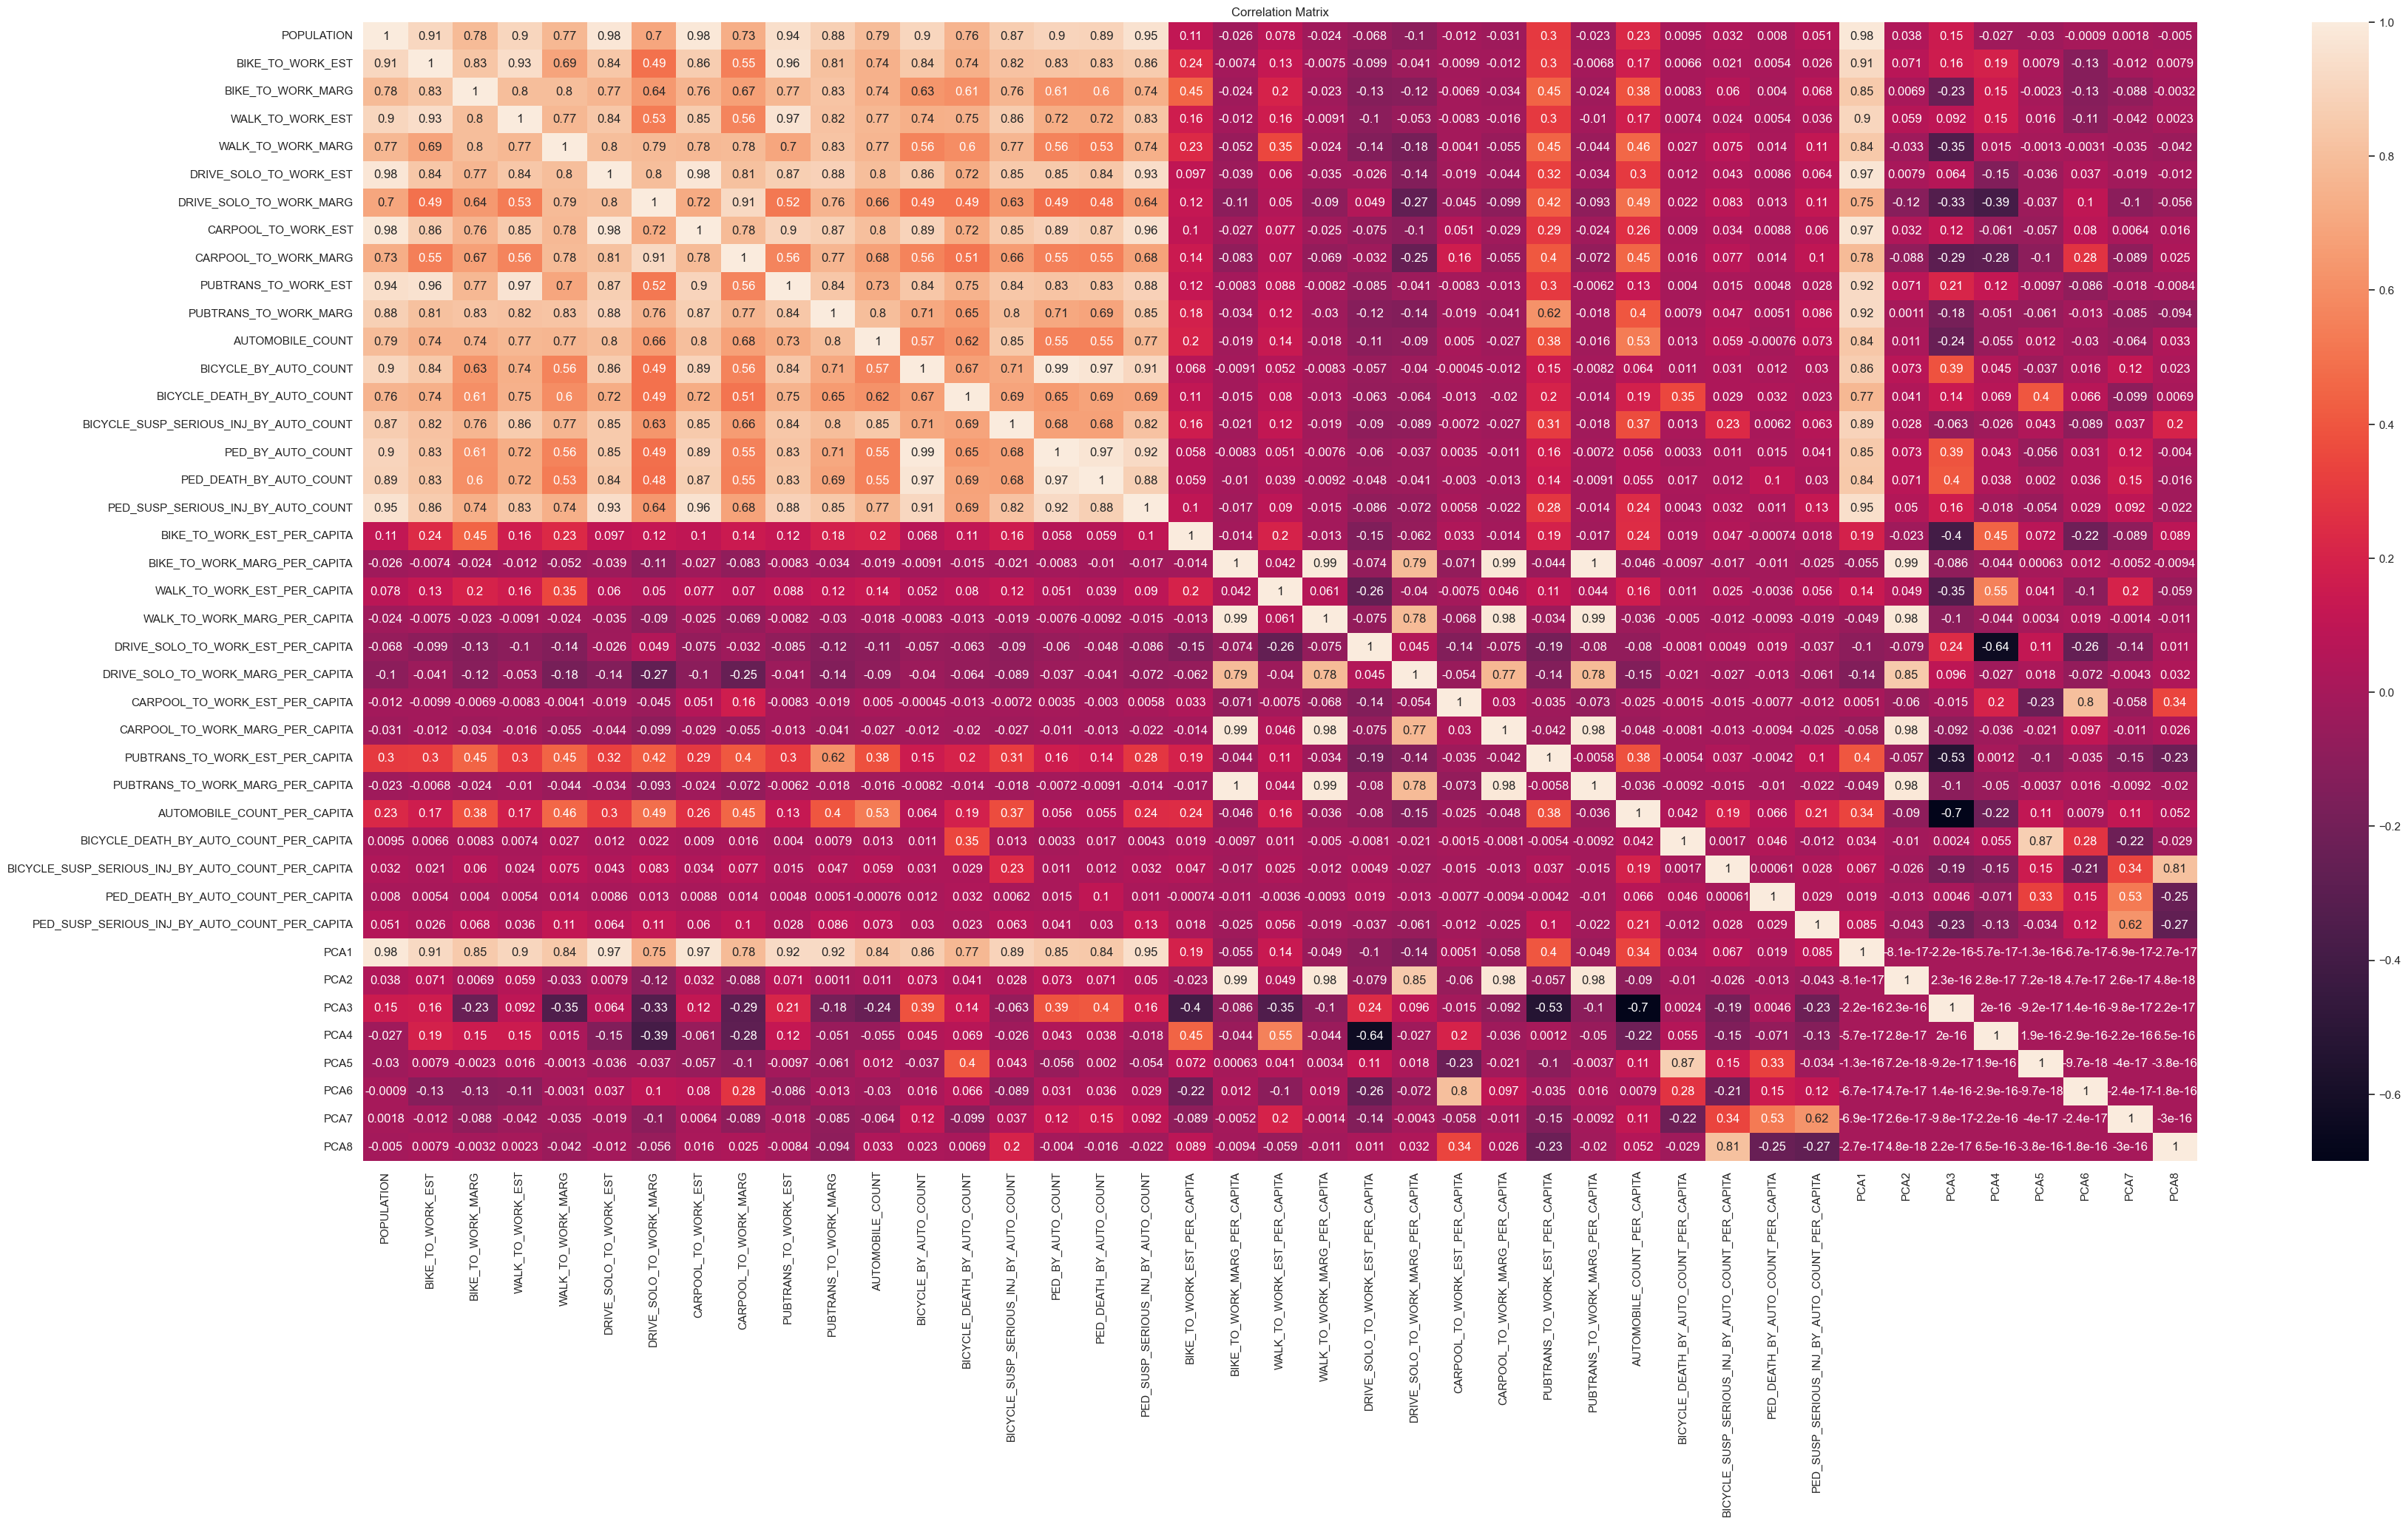

In [29]:
# Create heatmap
heat_corr = df_crash_filtered[['POPULATION', 'BIKE_TO_WORK_EST', 'BIKE_TO_WORK_MARG',
       'WALK_TO_WORK_EST', 'WALK_TO_WORK_MARG', 'DRIVE_SOLO_TO_WORK_EST',
       'DRIVE_SOLO_TO_WORK_MARG', 'CARPOOL_TO_WORK_EST',
       'CARPOOL_TO_WORK_MARG', 'PUBTRANS_TO_WORK_EST', 'PUBTRANS_TO_WORK_MARG',
       'AUTOMOBILE_COUNT', 'BICYCLE_BY_AUTO_COUNT',
       'BICYCLE_DEATH_BY_AUTO_COUNT', 'BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT',
       'PED_BY_AUTO_COUNT', 'PED_DEATH_BY_AUTO_COUNT',
       'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT', 'BIKE_TO_WORK_EST_PER_CAPITA',
       'BIKE_TO_WORK_MARG_PER_CAPITA', 'WALK_TO_WORK_EST_PER_CAPITA',
       'WALK_TO_WORK_MARG_PER_CAPITA', 'DRIVE_SOLO_TO_WORK_EST_PER_CAPITA',
       'DRIVE_SOLO_TO_WORK_MARG_PER_CAPITA', 'CARPOOL_TO_WORK_EST_PER_CAPITA',
       'CARPOOL_TO_WORK_MARG_PER_CAPITA', 'PUBTRANS_TO_WORK_EST_PER_CAPITA',
       'PUBTRANS_TO_WORK_MARG_PER_CAPITA', 'AUTOMOBILE_COUNT_PER_CAPITA',
       'BICYCLE_DEATH_BY_AUTO_COUNT_PER_CAPITA',
       'BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT_PER_CAPITA',
       'PED_DEATH_BY_AUTO_COUNT_PER_CAPITA',
       'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT_PER_CAPITA', 'PCA1', 'PCA2', 'PCA3',
       'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8']].corr()

plt.figure(figsize=(40,20))
sns.set(rc={ 'figure.facecolor':'w'})
sns.heatmap(heat_corr, annot=True) 
plt.title("Correlation Matrix")
plt.show()

In [31]:
# Create the table to visualize the correlations
df_crash_filtered[['POPULATION', 'BIKE_TO_WORK_EST', 'BIKE_TO_WORK_MARG',
       'WALK_TO_WORK_EST', 'WALK_TO_WORK_MARG', 'DRIVE_SOLO_TO_WORK_EST',
       'DRIVE_SOLO_TO_WORK_MARG', 'CARPOOL_TO_WORK_EST',
       'CARPOOL_TO_WORK_MARG', 'PUBTRANS_TO_WORK_EST', 'PUBTRANS_TO_WORK_MARG',
       'AUTOMOBILE_COUNT', 'BICYCLE_BY_AUTO_COUNT',
       'BICYCLE_DEATH_BY_AUTO_COUNT', 'BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT',
       'PED_BY_AUTO_COUNT', 'PED_DEATH_BY_AUTO_COUNT',
       'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT', 'BIKE_TO_WORK_EST_PER_CAPITA',
       'BIKE_TO_WORK_MARG_PER_CAPITA', 'WALK_TO_WORK_EST_PER_CAPITA',
       'WALK_TO_WORK_MARG_PER_CAPITA', 'DRIVE_SOLO_TO_WORK_EST_PER_CAPITA',
       'DRIVE_SOLO_TO_WORK_MARG_PER_CAPITA', 'CARPOOL_TO_WORK_EST_PER_CAPITA',
       'CARPOOL_TO_WORK_MARG_PER_CAPITA', 'PUBTRANS_TO_WORK_EST_PER_CAPITA',
       'PUBTRANS_TO_WORK_MARG_PER_CAPITA', 'AUTOMOBILE_COUNT_PER_CAPITA',
       'BICYCLE_DEATH_BY_AUTO_COUNT_PER_CAPITA',
       'BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT_PER_CAPITA',
       'PED_DEATH_BY_AUTO_COUNT_PER_CAPITA',
       'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT_PER_CAPITA', 'PCA1', 'PCA2', 'PCA3',
       'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8']].corr()

,POPULATION,BIKE_TO_WORK_EST,BIKE_TO_WORK_MARG,WALK_TO_WORK_EST,WALK_TO_WORK_MARG,DRIVE_SOLO_TO_WORK_EST,DRIVE_SOLO_TO_WORK_MARG,CARPOOL_TO_WORK_EST,CARPOOL_TO_WORK_MARG,PUBTRANS_TO_WORK_EST,...,PED_DEATH_BY_AUTO_COUNT_PER_CAPITA,PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT_PER_CAPITA,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8
POPULATION,1.000000,0.911685,0.781953,0.903612,0.772374,0.979810,0.697600,0.982490,0.731657,0.944423,...,0.008033,0.050965,9.820000e-01,3.818542e-02,1.514259e-01,-2.739553e-02,-2.965061e-02,-8.978883e-04,1.755436e-03,-4.997175e-03
BIKE_TO_WORK_EST,0.911685,1.000000,0.833561,0.934482,0.690860,0.835043,0.491666,0.862146,0.546420,0.955329,...,0.005430,0.025838,9.148905e-01,7.074450e-02,1.634409e-01,1.912940e-01,7.915182e-03,-1.264693e-01,-1.174237e-02,7.914724e-03
BIKE_TO_WORK_MARG,0.781953,0.833561,1.000000,0.796537,0.797949,0.765269,0.644913,0.758897,0.668431,0.767680,...,0.004039,0.067536,8.516938e-01,6.922100e-03,-2.348364e-01,1.509756e-01,-2.320155e-03,-1.282537e-01,-8.830234e-02,-3.219955e-03
WALK_TO_WORK_EST,0.903612,0.934482,0.796537,1.000000,0.772530,0.837197,0.530913,0.854744,0.562223,0.965298,...,0.005374,0.036392,9.038897e-01,5.942109e-02,9.197295e-02,1.532366e-01,1.614110e-02,-1.119858e-01,-4.164303e-02,2.272643e-03
WALK_TO_WORK_MARG,0.772374,0.690860,0.797949,0.772530,1.000000,0.798616,0.785549,0.776799,0.782330,0.699212,...,0.014213,0.112159,8.442917e-01,-3.315996e-02,-3.460683e-01,1.486926e-02,-1.312071e-03,-3.084545e-03,-3.532824e-02,-4.224586e-02
DRIVE_SOLO_TO_WORK_EST,0.979810,0.835043,0.765269,0.837197,0.798616,1.000000,0.799416,0.977128,0.813349,0.872717,...,0.008643,0.064015,9.685208e-01,7.945390e-03,6.364811e-02,-1.451341e-01,-3.633391e-02,3.687392e-02,-1.946887e-02,-1.202097e-02
DRIVE_SOLO_TO_WORK_MARG,0.697600,0.491666,0.644913,0.530913,0.785549,0.799416,1.000000,0.717826,0.914081,0.517124,...,0.012750,0.111479,7.451735e-01,-1.215448e-01,-3.314931e-01,-3.916075e-01,-3.730233e-02,1.005439e-01,-1.049274e-01,-5.647450e-02
CARPOOL_TO_WORK_EST,0.982490,0.862146,0.758897,0.854744,0.776799,0.977128,0.717826,1.000000,0.784343,0.895812,...,0.008763,0.060095,9.705507e-01,3.151144e-02,1.163843e-01,-6.064091e-02,-5.675014e-02,8.010489e-02,6.366371e-03,1.570652e-02
CARPOOL_TO_WORK_MARG,0.731657,0.546420,0.668431,0.562223,0.782330,0.813349,0.914081,0.784343,1.000000,0.563675,...,0.013650,0.102950,7.810487e-01,-8.846903e-02,-2.882638e-01,-2.834147e-01,-1.002687e-01,2.755637e-01,-8.931360e-02,2.463022e-02
PUBTRANS_TO_WORK_EST,0.944423,0.955329,0.767680,0.965298,0.699212,0.872717,0.517124,0.895812,0.563675,1.000000,...,0.004826,0.028277,9.237690e-01,7.133151e-02,2.104802e-01,1.178729e-01,-9.693859e-03,-8.557910e-02,-1.776167e-02,-8.395451e-03


### III. Ordinary Least Squares (OLS)

In [32]:
# Add PCA components into the dataframe
df_crash[["PCA1", "PCA2", "PCA3", "PCA4", "PCA5", "PCA6", "PCA7", "PCA8"]] = crash_pca_components[:]

**Separate data set in Y(independent) and X (dependent) variable**

In [33]:
y = df_crash["BICYCLE_BY_AUTO_COUNT_PER_CAPITA"] # Y = df_crash.BICYCLE_BY_AUTO_COUNT_PER_CAPITA
X = df_crash[["PCA1", "PCA2", "PCA3", "PCA4", "PCA5", "PCA6", "PCA7", "PCA8","penn"]] 

In [34]:
y2 = df_crash["PED_BY_AUTO_COUNT_PER_CAPITA"] # Y = df_crash.PED_BY_AUTO_COUNT_PER_CAPITA
X2 = df_crash[["PCA1", "PCA2", "PCA3", "PCA4", "PCA5", "PCA6", "PCA7", "PCA8","penn"]] 

**Use the train_test_split function to split your data into training (80%) and testing set (20%)**

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [36]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=5)

**Fit, run or estimate the regression model**

**BICYCLE_BY_AUTO_COUNT_PER_CAPITA is the dependent variable**

In [37]:
X_train = sm.add_constant(X_train)

In [38]:
model = sm.OLS(y_train, X_train).fit()

In [39]:
print(model.summary())

                                   OLS Regression Results                                   
Dep. Variable:     BICYCLE_BY_AUTO_COUNT_PER_CAPITA   R-squared:                       0.259
Model:                                          OLS   Adj. R-squared:                  0.256
Method:                               Least Squares   F-statistic:                     88.17
Date:                              Wed, 25 Oct 2023   Prob (F-statistic):          5.69e-141
Time:                                      14:41:08   Log-Likelihood:                 16738.
No. Observations:                              2286   AIC:                        -3.346e+04
Df Residuals:                                  2276   BIC:                        -3.340e+04
Df Model:                                         9                                         
Covariance Type:                          nonrobust                                         
                 coef    std err          t      P>|t|      [0.025    

**PED_BY_AUTO_COUNT_PER_CAPITA is the dependent variable**

In [40]:
X_train2 = sm.add_constant(X_train2)

In [41]:
model2 = sm.OLS(y_train2, X_train2).fit()

In [42]:
print(model2.summary())

                                 OLS Regression Results                                 
Dep. Variable:     PED_BY_AUTO_COUNT_PER_CAPITA   R-squared:                       0.429
Model:                                      OLS   Adj. R-squared:                  0.426
Method:                           Least Squares   F-statistic:                     189.6
Date:                          Wed, 25 Oct 2023   Prob (F-statistic):          6.75e-269
Time:                                  14:41:09   Log-Likelihood:                 15042.
No. Observations:                          2286   AIC:                        -3.006e+04
Df Residuals:                              2276   BIC:                        -3.001e+04
Df Model:                                     9                                         
Covariance Type:                      nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

**Plot the residuals for cyclists**

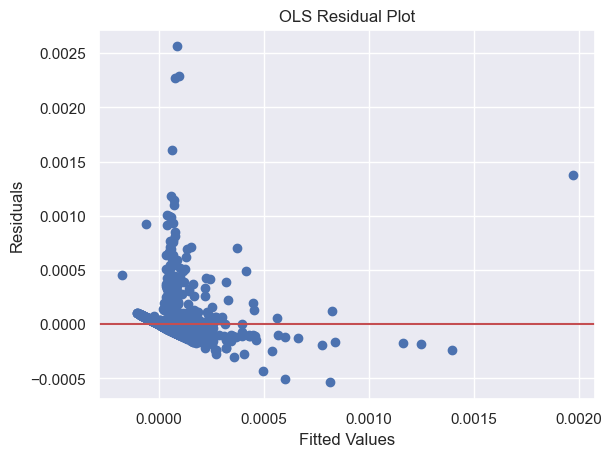

In [47]:
residuals = model.resid

plt.scatter(model.fittedvalues, residuals)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("OLS Residual Plot")
plt.axhline(y=0, color='r', linestyle='-')  # Add a horizontal line at y=0
plt.show()

**Plot the residuals for pedestrians**

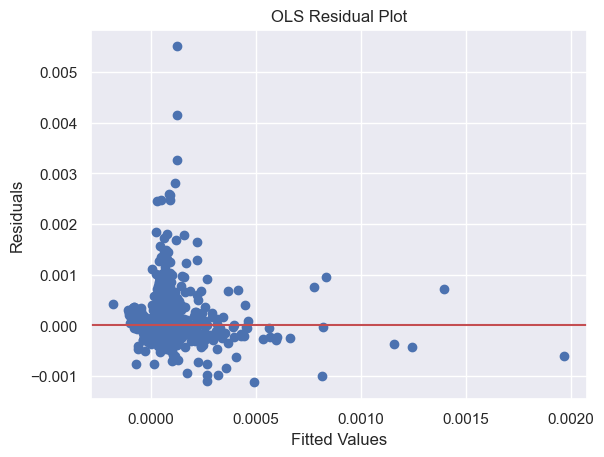

In [46]:
residuals2 = model2.resid

plt.scatter(model.fittedvalues, residuals2)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("OLS Residual Plot")
plt.axhline(y=0, color='r', linestyle='-')  # Add a horizontal line at y=0
plt.show()